In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

import sklearn.linear_model as linear_models
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from statsmodels.tsa.stattools import acf 
from statsmodels.stats.diagnostic import het_breuschpagan


In [2]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df)
df = df.sort_index(ascending=False)
df.dropna(inplace=True)


## assuming data exploration is complete, we go next to model building

In [3]:
def linear_evaluation(predictors, target): 
    lm = linear_models.LinearRegression()

    # cross-validation model analyses
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'explained_variance']
    lm_scores = cross_validate(lm, predictors, target, cv=5, scoring=scoring)

    # post-hoc model analyses using full dataset
    lm.fit(predictors, target)
    T = len(predictors) # of samples
    k = len(lm.coef_) # number of predictors
    residuals = lm.predict(predictors) - target
    SSE = np.sum(residuals.values**2)
    
    AIC = T * np.log(SSE/T) + (2 * (k+2))
    AICc = AIC + ((2*(k+2)*(k+3)) / (T-k-3))
    BIC = T * np.log(SSE/T) + (k+2) * np.log(T)
    r2_adj = 1 - (1-np.mean(lm_scores['test_r2']))*((T-1)/(T-k-1))

    analyses = dict(zip(scoring, [np.mean(lm_scores['test_' + metric]) for metric in scoring]))
    post_hoc = {'AIC': AIC, 'AIC bias corrected': AICc, 'BIC': BIC, 'r2 adjusted': r2_adj}
    analyses.update(post_hoc)

    analyses_df = pd.DataFrame.from_dict(analyses, orient='index').transpose()
    return lm, analyses_df

In [4]:
region = 'SoCal' # can be SD or SoCal
target = df[region + '_AMI_NONAMI_MDTH'] / df[region + '_CUST_COUNT']

predictor_dict = \
{'set_1': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_2': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', 
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_3': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_4': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_5': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
'set_6': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
}

In [5]:
#selecting optimal number of features
evaluation_df = pd.DataFrame()
for key, value in predictor_dict.items(): 
    lm, tmp_df = linear_evaluation(df[value], target)
    tmp_df.index = [key]
    evaluation_df = pd.concat([evaluation_df, tmp_df])
    
evaluation_df

,r2,neg_mean_absolute_error,neg_mean_squared_error,explained_variance,AIC,AIC bias corrected,BIC,r2 adjusted
set_1,0.975739,-0.000006,-9.132151e-11,0.977809,-35312.208980,-35311.194215,-35168.429958,0.975333
set_2,0.974832,-0.000006,-9.470059e-11,0.977114,-35263.039093,-35262.235342,-35135.235518,0.974461
set_3,0.970774,-0.000007,-1.080287e-10,0.971816,-34968.055935,-34967.647935,-34877.528403,0.970483
set_4,0.969497,-0.000008,-1.129490e-10,0.970679,-34901.089343,-34900.809902,-34826.537258,0.969254
set_5,0.968333,-0.000008,-1.164353e-10,0.969121,-34838.648744,-34838.240744,-34748.121212,0.968017
set_6,0.966699,-0.000008,-1.226460e-10,0.967593,-34760.228462,-34759.949021,-34685.676377,0.966434


In [12]:
def check_residuals(residual_df, predictors_df, nlags=21):
    """
    :param residual_df. dataframe that contains (1).index as time (2)['residuals'] as residuals
    """
    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(x=residual_df.index, y='residuals', data=residual_df, ax=ax1)
    sns.barplot(x=np.arange(0, nlags+1), y=acf(residual_df['residuals'], fft=False, nlags=nlags), ax=ax2)
    ax2.set_xlabel('lag'), ax2.set_ylabel('autocorrelation'), ax2.set_xticks(np.arange(0, nlags, 100)),
    ax2.set_xticklabels(np.arange(0, nlags, 100))
    sns.histplot(residual_df, ax=ax3)
    ax3.set_xlabel('residuals'), 
    plt.tight_layout(), plt.show()
    
    bp_test = het_breuschpagan(residual_df.iloc[:nlags]['residuals'], predictors_df.iloc[:nlags,:])
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(dict(zip(labels, bp_test)))
    
    if bp_test[1] > 0.05:
        print('WARNING: heteroscedasity detected. Residuals are not evenly distributed.')
    

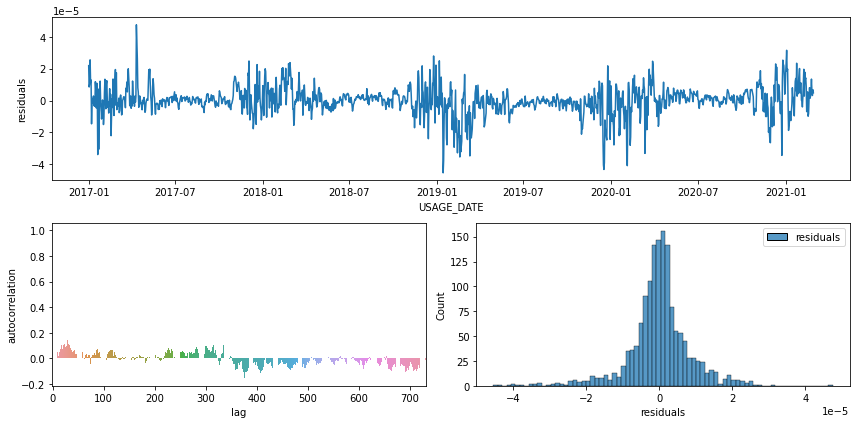

{'LM Statistic': 163.92342127900687, 'LM-Test p-value': 8.217038843288236e-23, 'F-Statistic': 8.506358823307119, 'F-Test p-value': 3.0097579804401206e-26}


In [13]:
lm = linear_models.LinearRegression()
predictors = df[predictor_dict['set_1']]
lm.fit(predictors, target)
residual_df = pd.DataFrame(lm.predict(predictors) - target)
residual_df.columns = ['residuals']

# h=10 for non-seasonal data and h=2m for seasonal data, where m is the period of seasonality
check_residuals(residual_df, predictors, nlags=730)